K-Means

In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm

In [2]:
sql = '''
SELECT *  FROM `eth-tokens.alldata.clean` LIMIT 1000000
'''

df = client.query(sql).to_dataframe()

In [3]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [4]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4

In [5]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)

cl.fit(results)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [6]:
#get centroids
c = cl.cluster_centers_
#transform back to real numbers
medoids = scale.inverse_transform(pca.inverse_transform(c))
pd.DataFrame(medoids, columns = data.columns)

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,active_months,monthly_outgoing_txns,monthly_incoming_txns,monthly_eth_sent,monthly_usd_sent,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent
0,3.210570e+01,2.731848e+01,4.835611e+02,78.958594,7.232910e+04,5531.735733,4.992388e+02,80.794361,6.776447e+04,4.776787e+03,15.890553,2.851661,2.620470,2.836694e+01,6.570324e+03,2.964820e+01,6.677903e+03,3.549207e-01,4.544397e+00
1,1.252250e+06,1.084444e+06,1.273841e+08,101.724147,8.922014e+09,7124.786883,5.432072e+07,50.090846,3.833821e+08,3.535288e+02,40.000000,31306.250000,27111.100000,3.184602e+06,2.230504e+08,1.358018e+06,9.584554e+06,1.000000e+00,5.780600e+04
2,1.207240e+06,1.586513e+05,8.793514e+06,5030.997722,1.691379e+09,655314.045363,6.195362e+06,4465.207435,6.434167e+08,2.094315e+05,24.321429,36765.906563,11929.273933,3.264291e+05,7.133835e+07,2.427872e+05,4.069539e+07,3.771821e+03,6.006686e+04
3,3.664460e+05,8.203125e+04,7.727411e+06,157.598400,3.467592e+09,77094.784201,7.922574e+06,2966.563156,3.531549e+09,1.626067e+06,13.750000,28279.744865,8207.791234,5.901831e+05,2.785969e+08,6.010452e+05,2.835143e+08,7.517842e-11,3.288383e-10


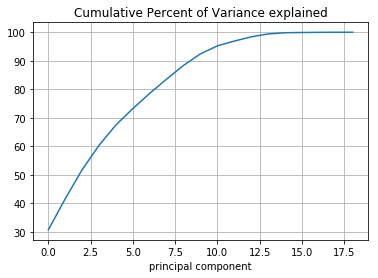

In [7]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

In [8]:
#plt.scatter(results[:,0],results[:,1],c=cl.labels_, s=5)

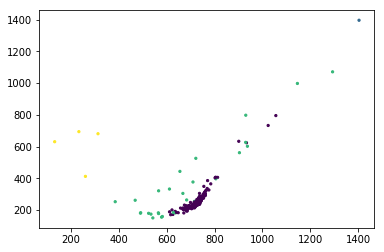

In [9]:
#plot in cluster distance space
r = cl.transform(results)
plt.scatter(r[:,3],r[:,2],c=cl.labels_, s=5)

In [10]:
#elbow method


In [11]:
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [2, 3,4,5,6,7,8,9,10,12,15,20,25, 40]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


Text(0.5,1,'Calinski Harabaz Scores')

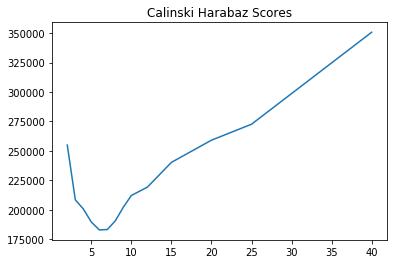

In [12]:
plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

Text(0,0.5,'within cluster sum of squares')

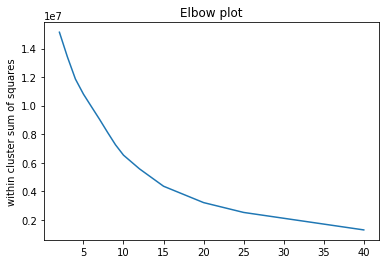

In [13]:
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')

In [14]:
#optmal number of clusters is around 12
cl = KMeans(12)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
#outlier removal



def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)


In [16]:
thresholds = np.linspace(.3,3, 20)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

Text(0.5,1,'Calinski Harabaz Scores as std threshold changes')

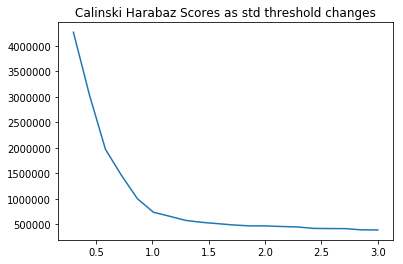

In [17]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [18]:
#empirical best threshold .75 stdev
newresults, labels = remove_outliers(results, cl,.75)

(-15, 10)

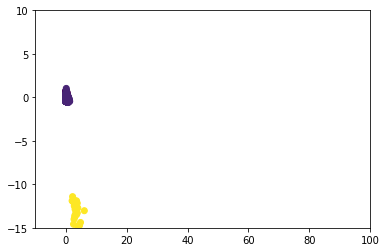

In [27]:
plt.scatter(newresults[:,0],newresults[:,1],c=labels)
plt.xlim(-10,100)
plt.ylim(-15,10)


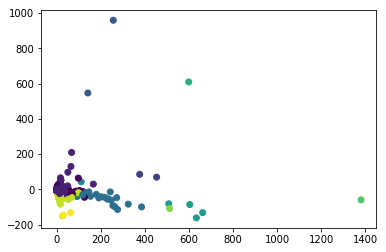

In [29]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)


In [21]:
#recluster after changes
newcl = KMeans(12).fit(newresults)

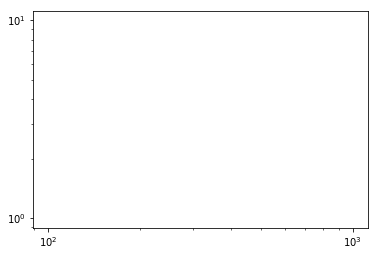

In [24]:
plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_, s=5)
